# NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

***officail site is [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)***

기본적인 단어 분류를 위한 문자단위 RNN(character-level RNN)을 만들고 학습시킬 겁니다. 이 튜토리얼에서는 torchtext의 편리한 기능들을 사용하지 않고 밑바닥에서부터 NLP의 모델링에 대해 어떻게 전처리하는지를 살펴볼 것입니다. 그래서 low level에서 NLP 모델링이 어떻게 전처리 되는지 알 수 있습니다.

문자 단위 RNN(character-level RNN)은 문자들의 연속을 읽어 들이고 각 단계에서 예측과 “hidden state” 출력하며 다음 단계에 이전 hidden state를 입력으로 전달합니다. 예를들어 그 단어가 어느 클래스에 속하는지와 같은 출력이되는 마지막 예측을 얻습니다

18개 언어로 된 수천 개의 성씨을 훈련시킨 다음 글자에 따라 이름이 어떤 언어의 성씨인지 예측합니다:

$ python predict.py Hinton  
(-0.47) Scottish  
(-1.52) English  
(-3.57) Irish 

$ python predict.py Schmidhuber  
(-0.19) German  
(-2.48) Czech  
(-2.68) Dutch


***추천 자료:***

최소한 Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다.:

- http://pytorch.org/ 설치 안내를 위한 자료
- [PyTorch로 딥러닝하기](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html): 60분만에 끝장내기 일반적인 PyTorch 시작을 위한 자료
- [예제로 배우는 PyTorch 넓고 깊은 통찰을 위한 자료](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
- [Torch 사용자를 위한 PyTorch](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) 이전 Lua Torch 사용자를 위한 자료

RNN과 RNN이 어떻게 동작하는지를 아는 것도 또한 유용합니다:

- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) 이 아티클은 실예제들을 보여 줍니다
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 주로 LSTM에 관한 것이지만 일반적인 RNN에 대하여도 유익한 정보입니다

## 데이터 준비하기

**[여기](https://download.pytorch.org/tutorial/data.zip)에서 데이터를 다운 받고, 현재 디렉토리에 압축을 풀어야 합니다**

`data/names` 폴더에는 “[Language].txt” 라는 18 개의 텍스트 파일이 포함되어 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 표시되어 있습니다 (그러나, 여전히 유니 코드에서 ASCII로 변환해야 합니다).

각 언어당 `{language : [names ...]}`라는 이름 리스트의 사전으로 완성될 것입니다. 일반 변수 “category” 와 “line” (이 경우 언어와 이름 용)은 이후의 확장성을 위해 사용됩니다.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니 코드 문자열을 일반 ASCII로 변환하십시오. http://stackoverflow.com/a/518232/2809427 에 감사드립니다.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 언어별 이름 목록인 category_lines 사전을 만드십시오.
category_lines = {}
all_categories = []

# 파일을 읽고 라인으로 분리하십시오
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/names/Chinese.txt', 'data/names/names/Czech.txt', 'data/names/names/German.txt', 'data/names/names/French.txt', 'data/names/names/Greek.txt', 'data/names/names/Portuguese.txt', 'data/names/names/Irish.txt', 'data/names/names/English.txt', 'data/names/names/Italian.txt', 'data/names/names/Japanese.txt', 'data/names/names/Polish.txt', 'data/names/names/Spanish.txt', 'data/names/names/Scottish.txt', 'data/names/names/Korean.txt', 'data/names/names/Russian.txt', 'data/names/names/Dutch.txt', 'data/names/names/Arabic.txt', 'data/names/names/Vietnamese.txt']
Slusarski


이제 각 카테고리(언어)를 라인의 리스트(이름)에 매핑하는 사전인 `category_lines`가 있습니다. 나중에 참조를 위하여 `all_categories`(단순한 언어 목록)과 `n_categories`를 추적합니다. 

In [2]:
category_lines.keys()

dict_keys(['Chinese', 'Czech', 'German', 'French', 'Greek', 'Portuguese', 'Irish', 'English', 'Italian', 'Japanese', 'Polish', 'Spanish', 'Scottish', 'Korean', 'Russian', 'Dutch', 'Arabic', 'Vietnamese'])

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 이름을 Tensor 로 변환

이제 위에서 정리된 모든 이름이 있으므로 이를 활용하기 위해 이름들을 Tensor로 전환해야 합니다.

하나의 문자를 표현하기 위해, 크기가 `<1 x n_letters>` 인 "one-hot vector" 를 사용합니다. one-hot 벡터는 현재 문자의 주소에만 1을 값을 가지고 그외에 나머지는 0으로 채워진 것입니다. 에를들어 `"b"= <0 1 0 0 0 …>`

단어를 만들기 위해 그 묶음을 2 차원 행렬 `<line_length x 1 x n_letters>` 에 결합시킵니다.

이 추가적인 1차원은 PyTorch가 모든 것이 배치(batch)에 있다고 가정하기 때문인 것입니다. 여기 배치크기는 1입니다.

In [4]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 문자를 <1 x n_letters> Tensor로 변환하기
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 문자 벡터의 어레이로 변경하기
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 네트워크 생성

Autograd 하기 전에, Torch에서 recurrent neural network를 만드는 것은 여러 타임 스텝을 거쳐 Layer의 파라미터를 복제하는 것을 포함합니다. 이제 레이어들은 그래프 안에서 완전히 처리되는 hidden state와 gradient를 가집니다. 이 말은 일반적인 feed-forward layer 같은 매우 "순수한" 방법으로 RNN을 구현할 수 있다는 겁니다.

이 RNN 모듈은 (대부분 [Torch 사용자를 위한 PyTorch 튜토리얼](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html) 에서 내용을 가져온) input과 hidden state에서 작동하는 2개의 선형 레이어이며 이 선형레이어의 결과는 LogSoftmax 레이어를 가집니다.

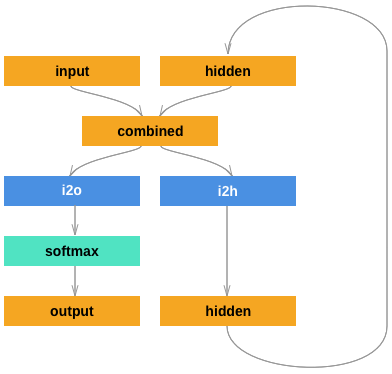

In [5]:
from IPython.display import Image
Image("images/classifying_names_with_a_character-level-rnn.png") 

In [6]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

이 네트워크를 실행하려면 입력(여기서는 현재 문자에 대한 Tensor)과 이전의 hidden state를(처음에 0으로 초기화한) 전달해야 합니다. 그리고 출력(각 언어의 확률)과 다음 hidden state (다음 단계를 위해 유지하는)를 돌려 받을겁니다.

In [7]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

효율성을 위해서 매 단계마다 새로운 Tensor를 만들고 싶지 않기 때문에 `letterToTensor` 대신에 `lineToTensor`와 slices를 사용할 것입니다. 이것은 Tensor의 사전 계산(pre-computing) 배치에 의해 더욱 최적화 될 수 있습니다.

In [8]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9355, -2.9031, -2.8683, -2.9005, -2.7692, -2.9290, -2.8897, -2.8672,
         -2.8993, -3.0159, -2.8448, -2.8715, -2.8880, -2.9263, -2.8987, -2.8975,
         -2.8706, -2.8716]], grad_fn=<LogSoftmaxBackward>)


보는바와 같이 출력은 매 항목이 해당 카테고리의 likelihood(값이 높을 수록 가능성이 높은)인 `<1 x n_categories>` Tensor입니다

## 학습

### 학습 준비

학습으로 들어가기 전에 몇몇 도움될만한 함수를 만들어야합니다. 첫째는 네트워크의 출력을 해석하기 위한 것 입니다. 이는 각 카테고리의 likelihood가 되는 것입니다. 가장 큰 값의 주소를 알기 위해서 `Tensor.topk` 를 쓸 수 있습니다.

In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', tensor(4))


또한 학습 example을(이름과 언어)를 얻는 빠른 방법을 원할 것입니다.

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Marik
category = Arabic / line = Khouri
category = Italian / line = Manco
category = Scottish / line = Mcmillan
category = German / line = Rothenberg
category = English / line = Elcock
category = Greek / line = Papoutsis
category = English / line = Jeffrey
category = Arabic / line = Daher
category = Spanish / line = Gallego


### 네트워크 학습

이제 이 네트워크를 훈련하는 데 필요한 모든것은 네트워크에 예시를 주고 추측을 하고, 만일 잘못되었다면 알려주는 것 입니다.

loss function에는 RNN의 마지막 레이어가 nn.LogSoftmax 이므로 `nn.NLLLoss`가 적절합니다.

In [11]:
criterion = nn.NLLLoss()

학습의 각 루프에는 다음이 실행됩니다:

- 입력과 목표 tensor 생성
- 0로 초기화된 hidden state 생성
- 각 문자를 읽기
    - 그 후 다음 문자를 위하여 hidden state 유지
- 목표와 출력 비교
- 역전파(Back-propagate)
- 출력과 손실 리턴

In [14]:
learning_rate = 0.005 # 이것을 너무 높게 설정하면 폭발할 수 있고 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # learning rate를 곱한 파리미터의 경사도를 파리미터 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

이제 예제를 사용하여 실행해야합니다. train 함수가 출력과 손실을 반환하기 때문에 추측을 출력하고 도식화를 위한 손실을 추적 할 수 있습니다. 1000개의 예제가 있기 때문에 모든 print_every 예제만 출력하고 손실의 평균을 얻습니다.

In [15]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 소실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 2.6697 Lian / Irish ✗ (Chinese)
10000 10% (0m 33s) 1.6258 Dickson / Scottish ✓
15000 15% (0m 51s) 2.6767 Alst / English ✗ (Dutch)
20000 20% (1m 8s) 2.1710 Szweda / Dutch ✗ (Polish)
25000 25% (1m 24s) 1.2104 Quyen / Korean ✗ (Vietnamese)
30000 30% (1m 40s) 0.8904 Chan / Chinese ✓
35000 35% (1m 57s) 0.8382 Le / Vietnamese ✓
40000 40% (2m 14s) 1.8507 Chaim / Vietnamese ✗ (Chinese)
45000 45% (2m 30s) 1.7346 Antar / Scottish ✗ (Arabic)
50000 50% (2m 46s) 1.4998 Moller / German ✓
55000 55% (3m 3s) 1.4658 Rijnder / German ✗ (Dutch)
60000 60% (3m 20s) 0.7704 Maurice / Irish ✓
65000 65% (3m 36s) 2.1700 Cameron / French ✗ (Scottish)
70000 70% (3m 52s) 0.1605 Sotiris / Greek ✓
75000 75% (4m 8s) 0.1561 Pappayiorgas / Greek ✓
80000 80% (4m 26s) 0.1117 Kassab / Arabic ✓
85000 85% (4m 41s) 1.1587 Jimenez / Spanish ✓
90000 90% (4m 57s) 0.5648 Seah / Chinese ✓
95000 95% (5m 14s) 1.7474 Costa / Italian ✗ (Spanish)
100000 100% (5m 30s) 1.9919 Mingo / Portuguese ✗ (Spanish)


### 결과 플롯(plotting)

`all_losses`에서 historical loss를 플롯팅(plotting)하는 것은 네트워크 학습을 보여줍니다.

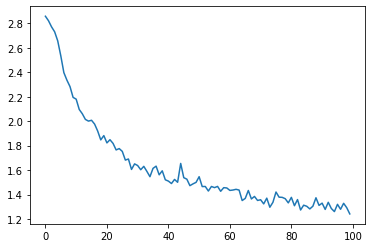

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 결과 평가

다른 카테고리에 대한 네트워크 성능이 얼마나 잘됐는지 보기위해 네트워크가 추측하는 언어(열)와 실제 언어(행)를 가리키는 confusion matrix을 만듭니다. confusion matrix을 계산하기 위해 많은 수의 샘플들이 `train()`과 역전파를 빼면 동일한 `evaluate()`로 네트워크를 거쳐 실행됩니다.

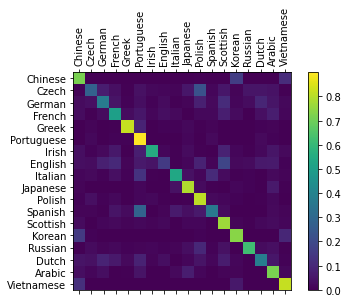

In [19]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 올바르게 추측 된 예시와 기록을 살펴보십시오.
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나눔으로써 정규화하십시오.
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 강제로 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

주축(main axis)에서 벗어난 밝은 점을 표시하여 잘못 추측한 언어를 표시 할 수 있습니다. 예를 들어 한국어에 대한 중국어, 이탈리아어에 대한 스페인어. 그리스어는 매우 잘되는 것으로 영어는 매우 나쁜것 같습니다. (아마도 다른 언어들과 중첩되기 때문에 그런걸 수도 있습니다.)

### 사용자 입력으로 실행

In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # 최고 N 카테고리 얻기
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.86) Russian
(-1.50) Polish
(-1.64) Czech

> Jackson
(-0.19) Scottish
(-2.42) English
(-3.37) Russian

> Satoshi
(-0.86) Arabic
(-1.41) Japanese
(-2.07) Italian


[in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) 최종 버전 스크립트는 위 코드를 몇개의 파일로 분할했습니다.:

- `data.py` (파일 읽기)
- `model.py` (RNN 정의)
- `train.py` (학습 실행)
- `predict.py` (커멘드 라인 인자로 `predict()` 실행)
- `server.py` (bottle.py를 사용하여 JSON API로 예측 제공)

학습과 네트워크 저장을 위해 `train.py` 실행.

이름으로 예측을 보기 위해 `predict.py` 실행:

$ python predict.py Hazaki  
(-0.42) Japanese  
(-1.39) Polish  
(-3.51) Czech

server.py 를 실행하고 prediction JSON 출력을 얻기 위해 http://localhost:5533/Yourname 를 참고하세요

## 연습

- “line -> category”인 다른 데이터 집합으로 시도해보세요, 예를 들어:
    - 단어 -> 언어
    - 이름 -> 성별
    - 캐릭터 이름 -> 작가
    - 페이지 제목 -> 블로그 또는 서브레딧
- 더 크고 더 나은 모양의 네트워크로 더 나은 결과를 얻어보세요.
    - 더 많은 linear layer 추가해 보십시오
    - `nn.LSTM` 과 `nn.GRU` layer 추가해 보십시오
    - 여러 개의 이런 RNN을 상위 수준 네트워크로 결합해 보십시오